In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # for intractve graphs

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/DA_Assignment/input/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import nltk
from nltk.corpus import stopwords

In [0]:
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

In [0]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [0]:
train_data = pd.read_csv("train.csv", header=0)
test_data = pd.read_csv("test.csv", header=0)

In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [0]:
train_data.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


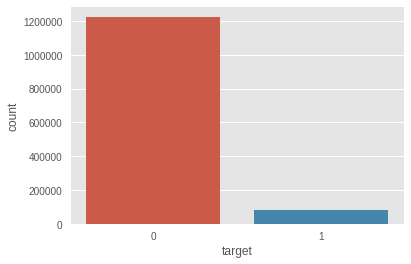

In [0]:
sns.countplot("target",data=train_data)

In [0]:
# now let us check in the number of Percentage
Count_Sincere_Questions = len(train_data[train_data["target"]==0]) 
Count_Insincere_Questions = len(train_data[train_data["target"]==1]) 
Percentage_of_Sincere_Questions = Count_Sincere_Questions/(Count_Sincere_Questions+Count_Insincere_Questions)
print("percentage of Sincere Questions is",Percentage_of_Sincere_Questions*100)
Percentage_of_Insincere_Questions= Count_Insincere_Questions/(Count_Sincere_Questions+Count_Insincere_Questions)
print("percentage of Insincere Questions",Percentage_of_Insincere_Questions*100)

percentage of Sincere Questions is 93.81298224821265
percentage of Insincere Questions 6.187017751787352


In [0]:
insincere_indices= np.array(train_data[train_data.target==1].index)
normal_indices = np.array(train_data[train_data.target==0].index)
#now let us a define a function for make undersample data with different proportion
#different proportion means with different proportion of normal classes of data
def undersample(normal_indices,insincere_indices,times):#times denote the Sincere_Data = times*Insincere_Data
    Normal_indices_undersample = np.array(np.random.choice(normal_indices,(times*Count_Insincere_Questions),replace=False))
    print(len(Normal_indices_undersample))
    undersample_data= np.concatenate([insincere_indices,Normal_indices_undersample])

    undersample_data = train_data.iloc[undersample_data,:]
    #print(undersample_data)
    print(len(undersample_data))

    print("the sincere questions proportion is :",len(undersample_data[undersample_data.target==0])/len(undersample_data))
    print("the insincere questions proportion is :",len(undersample_data[undersample_data.target==1])/len(undersample_data))
    print("total number of record in resampled data is:",len(undersample_data))
    return(undersample_data)

In [0]:
Undersample_data = undersample(normal_indices,insincere_indices,4)

323240
404050
the sincere questions proportion is : 0.8
the insincere questions proportion is : 0.2
total number of record in resampled data is: 404050


In [0]:
Undersample_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404050 entries, 22 to 942465
Data columns (total 3 columns):
qid              404050 non-null object
question_text    404050 non-null object
target           404050 non-null int64
dtypes: int64(1), object(2)
memory usage: 12.3+ MB


In [0]:
Undersample_data = Undersample_data.reset_index()
train_text = Undersample_data['question_text']
test_text = test_data['question_text']
train_target = Undersample_data['target']
all_text = train_text.append(test_text)

In [0]:
#fit and transform

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(all_text)

count_vectorizer = CountVectorizer()
count_vectorizer.fit(all_text)

train_text_features_cv = count_vectorizer.transform(train_text)
test_text_features_cv = count_vectorizer.transform(test_text)

train_text_features_tf = tfidf_vectorizer.transform(train_text)
test_text_features_tf = tfidf_vectorizer.transform(test_text)

In [0]:
type(Undersample_data)

pandas.core.frame.DataFrame

In [0]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 2018)
test_preds1 = 0
oof_preds1 = np.zeros([Undersample_data.shape[0],])
test_preds2 = 0
oof_preds2 = np.zeros([Undersample_data.shape[0],])



for i, (train_idx, valid_idx) in enumerate(kfold.split(Undersample_data)):
    x_train, x_valid = train_text_features_cv[train_idx,:],train_text_features_cv[valid_idx,:]
    y_train, y_valid = train_target[train_idx], train_target[valid_idx]
    classifier1 = MultinomialNB()
    classifier2 = BernoulliNB()
    print('fitting.......')
    classifier1.fit(x_train,y_train)
    classifier2.fit(x_train,y_train)
    print('predicting......')
    print('\n')
    
    oof_preds1[valid_idx] = classifier1.predict_proba(x_valid)[:,1]
    test_preds1 += 0.2*classifier1.predict_proba(test_text_features_cv)[:,1]
    oof_preds2[valid_idx] = classifier2.predict_proba(x_valid)[:,1]
    test_preds2 += 0.2*classifier2.predict_proba(test_text_features_cv)[:,1]

fitting.......
predicting......


fitting.......
predicting......


fitting.......
predicting......


fitting.......
predicting......


fitting.......
predicting......




In [0]:
pred_train = (oof_preds1 > .3).astype(np.int)
f1_score(train_target, pred_train)

0.7259731194928286

In [0]:
pred_train = (oof_preds2 > .3).astype(np.int)
f1_score(train_target, pred_train)

0.726945943787016